In [1]:
#dl.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#24 January 2018

In [2]:
#import matplotlib pandas etc
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
pd.set_option('display.max_columns', None)
pd.set_option('display.height', None)
pd.set_option('display.width', None)

height has been deprecated.



In [3]:
#read books dataframe
import pickle
with open('chunks.pkl', 'rb') as fp:
    chunks = pickle.load(fp)
print 'number of records = ', len(chunks)
print 'number of books = ', len(chunks['input_file'].unique())
chunks.head()

number of records =  126114
number of books =  89


,author,author_id,title,input_file,text_chunk
96074,A.H. Clough,0,Plutarch's Lives,iso/etext96/plivs10.txt,"and their infantry, who were placed in the lef..."
38665,Percy Bysshe Shelley,65,The Complete Poetical Works of Percy Bysshe,iso/etext03/shlyc10.txt,"One of their associates is, to my knowledge, a..."
74739,Kate Milner Rabb,51,National Epics,iso/etext05/8ntle10.txt,strong car in which to carry away the soiled g...
75323,Kate Milner Rabb,51,National Epics,iso/etext05/8ntle10.txt,his honor in the land grows greater day by day...
84031,Austen,7,Sense And Sensibility,iso/etext94/sense11.txt,and my cousins would be proud to know her.--My...


In [4]:
#show titles and number of chunks
#need to fix Austnn & Jane Austen
N = pd.DataFrame(chunks.groupby(['author', 'title', 'input_file'])['text_chunk'].count()).reset_index()\
    .sort_values('author')
N = N.rename(columns={'text_chunk':'N_chunks'})
N.head()

,author,title,input_file,N_chunks
0,A.H. Clough,Plutarch's Lives,iso/etext96/plivs10.txt,2200
1,Adam Smith,Wealth Of Nations,iso/etext02/wltnt10.txt,2200
2,Adams,The Education Of Henry Adams,iso/etext00/eduha10.txt,1260
3,Anne C. Lynch Botta,Handbook Of Universal Literature,iso/etext05/8unlt10.txt,1699
4,Anthony Trollope,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,2200


In [5]:
#select 3 books
records = chunks
id0 = 12 #Don Quijote in Spanish
id1 = 79 #bullfinch Mythology
id2 = 82 #Le Mort D'Arthur
idx = (records['author_id'] == id0) | (records['author_id'] == id1) | (records['author_id'] == id2)
records = records[idx].copy()
records['author_id'] = records['author_id'].replace({id0:0, id1:1, id2:2})#, axis=1)
records.head(20)

,author,author_id,title,input_file,text_chunk
111052,Thomas Malory,2,Le Mort D'Arthur,iso/etext98/2mart10.txt,"Fair fellows, said Galihodin, yonder come four..."
124876,"Cervantes, In Spanish",0,Don Quijote,iso/etext99/2donq10.txt,ordenado: que todas las mujeres se entrasen en...
125284,"Cervantes, In Spanish",0,Don Quijote,iso/etext99/2donq10.txt,"que �l har�a que el marqu�s, su hermano, fuese..."
53798,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,"they brought before the king. Pentheus, behold..."
53873,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,preparation of a robe for the funeral canopy o...
51879,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,"he offered her a goblet of liquor. ""Drink this..."
123999,"Cervantes, In Spanish",0,Don Quijote,iso/etext99/2donq10.txt,"las cosas tienen remedio, si no es la muerte, ..."
52776,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,Sad and sorrowful was the maiden as she saw al...
123826,"Cervantes, In Spanish",0,Don Quijote,iso/etext99/2donq10.txt,"salir, ora fuese visto o no, con determinaci�n..."
52912,Thomas Bulfinch,1,Bulfinch'S Mythology,iso/etext04/bllfn10.txt,"go to the grotto of Galatea, and tell her how ..."


In [6]:
#train-test-validate split
train_size = 0.33
validate_size=0.5   #this is the fraction of the test sample that is assigned to the validation sample
rn_seed = 12
from sklearn.model_selection import train_test_split
train, test = train_test_split(records, train_size=train_size, random_state=rn_seed)
validate, test = train_test_split(test, train_size=validate_size, random_state=rn_seed)
print 'records.shape  = ', records.shape
print 'train.shape    = ', train.shape
print 'test.shape     = ', test.shape
print 'validate.shape = ', validate.shape

records.shape  =  (5782, 5)
train.shape    =  (1908, 5)
test.shape     =  (1937, 5)
validate.shape =  (1937, 5)


In [7]:
#confirm that all 90 books have records in the training sample
print len(train['input_file'].unique()), len(records['input_file'].unique())

3 3


In [8]:
#count word frequencies...there are 500K distinct words used in these books, really???
#i'm not sure about the...maybe this is due to lack of treatment of punctuation characters
from collections import defaultdict
word_frequency = defaultdict(int)
corpus = records['text_chunk'].tolist()
for doc in corpus:
    words = doc.split(' ')
    for word in words:
        word_frequency[word] += 1
print 'number of distinct words = ', len(word_frequency.keys()) 
for word in word_frequency.keys()[1:7]:
    print word, word_frequency[word]

number of distinct words =  56979
llana, 1
vuestra? 1
Poetry 1
rufi�n, 1
woods 13
hanging 10


In [9]:
#generate tokenizer
vocabulary_size = 60000
N_inputs = 100
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=vocabulary_size)

Using TensorFlow backend.


In [10]:
#this helper function extracts and tokenizes x, and extracts y and onehot-encodes it
from keras.utils import np_utils
def tokenize(df, tokenizer):
    corpus = df['text_chunk'].tolist()
    tokenizer.fit_on_texts(corpus)
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
    x = np.array(corpus_padded)
    y_ids = df['author_id'].values
    y = np_utils.to_categorical(y_ids)
    return x, y

In [11]:
#get training x,y with x-values being tokenized and y values onehot-encoded
x_train, y_train = tokenize(train, tokenizer)
N_inputs = x_train.shape[1]
N_outputs = y_train.shape[1]
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
print 'N_inputs = ', N_inputs
print 'N_outputs = ', N_outputs
print 'vocabulary_size = ', vocabulary_size, x_train.min(), x_train.max()

x_train.shape =  (1908, 100)
y_train.shape =  (1908, 3)
N_inputs =  100
N_outputs =  3
vocabulary_size =  60000 0 18573


In [12]:
#display a training record
idx = 121
print train.iloc[idx]
text_chunk = train.iloc[idx]['text_chunk']
print text_chunk
print x_train[idx]
print y_train[idx]

author                                          Thomas Bulfinch
author_id                                                     1
title                                      Bulfinch'S Mythology
input_file                              iso/etext04/bllfn10.txt
text_chunk    up, called on his companions to seek with him ...
Name: 52316, dtype: object
up, called on his companions to seek with him a place of safety. On the right they found an adjoining chamber, into which the others entered, but Thor remained at the doorway with his mallet in his hand, prepared to defend himself, whatever might happen. A terrible groaning was heard during the night, and at dawn of day Thor went out and found lying near him a huge giant, who slept and snored in the way that had alarmed them so. It is said that for once Thor was afraid to use his mallet, and as the giant soon waked 
[  166   201    51    12  1137     8   446    22    19     4   287     5
  2554    51     1   224    25   174    85  6589   492   1

In [13]:
#show that the vectorized text preserves word order while dropping punctuation
tokens = []
words_marked = text_chunk.split(' ')[0:15]
words = [word.lower().strip(',').strip('.') for word in words_marked]
tokens = [tokenizer.word_index[word] for word in words]
print words
print tokens

['up', 'called', 'on', 'his', 'companions', 'to', 'seek', 'with', 'him', 'a', 'place', 'of', 'safety', 'on', 'the']
[166, 201, 51, 12, 1137, 8, 446, 22, 19, 4, 287, 5, 2554, 51, 1]


In [14]:
#get validation x,y with x-values being tokenized and y values onehot-encoded
x_valid, y_valid = tokenize(validate, tokenizer)
print 'x_valid.shape = ', x_valid.shape
print 'y_valid.shape = ', y_valid.shape

x_valid.shape =  (1937, 100)
y_valid.shape =  (1937, 3)


In [15]:
#display a validation record
idx = 123
print validate.iloc[idx]
print validate.iloc[idx]['text_chunk']
print x_valid[321]
print y_valid[321]

author                                            Thomas Malory
author_id                                                     2
title                                          Le Mort D'Arthur
input_file                              iso/etext98/2mart10.txt
text_chunk    was in a castle there besides Surluse; and the...
Name: 110884, dtype: object
was in a castle there besides Surluse; and there encountered with him a worshipful duke, and there Sir Palomides smote him over his horse's croup. And this duke was uncle unto King Arthur. Then Sir Elise's son rode unto Palomides, and Palomides served Elise in the same wise. When Sir Uwaine saw this he was wroth. Then he took his horse and encountered with Sir Palomides, and Palomides smote him so hard that he went to the earth, horse and man. And for to make a short tale, he smote down three brethren of Sir Gawaine, that is for to 
[    1    82   301   747  8755 13118     5 22205 20618 24222 13222 11602
    14  1203   202  3813     5  3028 204

In [16]:
##architect a simple LSTM model...this one is adapted from 
##https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
#from keras.layers import Embedding, LSTM, Dense, Dropout#, Conv1D, MaxPooling1D, Activation
#from keras.models import Sequential
#from keras.models import Sequential
#from keras.layers import Dense
#def build_simple_lstm_model(N_inputs, N_hidden, N_outputs,):
#    model = Sequential()
#    model.add(Dense(N_hidden, input_dim=N_inputs, activation='relu'))
#    model.add(Dense(N_outputs, activation='softmax'))
#    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model

In [17]:
##build a better LSTM model...this one is adapted from 
##http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews
#from keras.layers import Embedding, LSTM, Dense, Dropout#, Conv1D, MaxPooling1D, Activation
#from keras.models import Sequential
#def build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length):
#    model = Sequential()
#    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=N_inputs))
#    model.add(LSTM(embedding_vector_length, dropout=0.2, recurrent_dropout=0.2))
#    model.add(Dense(N_outputs, activation='softmax'))
#    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model

In [18]:
##this is a half-assed version of 
##https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6
#def build_lstm_model(N_inputs, N_outputs):
#    model = Sequential()
#    model.add(Dense(N_inputs, input_shape=(1,), activation='tanh'))
#    model.add(Dense(N_inputs/2, activation='tanh'))
#    dense_inputs = int(np.sqrt(N_inputs + N_outputs))
#    model.add(Dense(dense_inputs, activation='tanh'))
#    model.add(Dense(N_outputs, activation='softmax'))
#    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model
#lstm_model = build_lstm_model(N_inputs, N_outputs)

In [79]:
#build an even better LSTM model...this one was adapted from
#http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.models import Sequential
def build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size, 
        dropout_fraction):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=N_inputs))
    model.add(Dropout(dropout_fraction))
    N_classes = 2.5
    conv_size = int(N_classes*embedding_vector_length)
    model.add(Conv1D(conv_size, conv_kernel_size, activation='linear'))
    pool_size = int(conv_kernel_size/2)
    model.add(MaxPooling1D(pool_size=pool_size))
    lstm_size = int(embedding_vector_length/pool_size)
    model.add(LSTM(lstm_size, activation='linear'))
    model.add(Dropout(dropout_fraction))
    model.add(Dense(N_outputs, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [96]:
#assemble the lstm model
N_training_epochs = 150
batch_size = 7000
embedding_vector_length = 25
conv_kernel_size = 12
dropout_fraction = 0.85
rn_seed = 16
print 'N_training_epochs = ', N_training_epochs
print 'batch_size = ', batch_size
print 'number of samples = ', x_train.shape[0] + x_valid.shape[0]
print 'vocabulary_size = ', vocabulary_size
print 'embedding_vector_length = ', embedding_vector_length
print 'conv_kernel_size = ', conv_kernel_size
print 'dropout_fraction = ', dropout_fraction
print 'N_inputs = ', N_inputs, x_train.shape[1]
print 'N_outputs = ', N_outputs, y_train.shape[1]
print 'rn_seed = ', rn_seed
import random
random.seed(rn_seed)
lstm_model = build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size,
    dropout_fraction)

N_training_epochs =  150
batch_size =  7000
number of samples =  3845
vocabulary_size =  60000
embedding_vector_length =  25
conv_kernel_size =  12
dropout_fraction =  0.85
N_inputs =  100 100
N_outputs =  3 3
rn_seed =  16


In [97]:
#fit model to the training data
fit_history = lstm_model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_valid, y_valid))

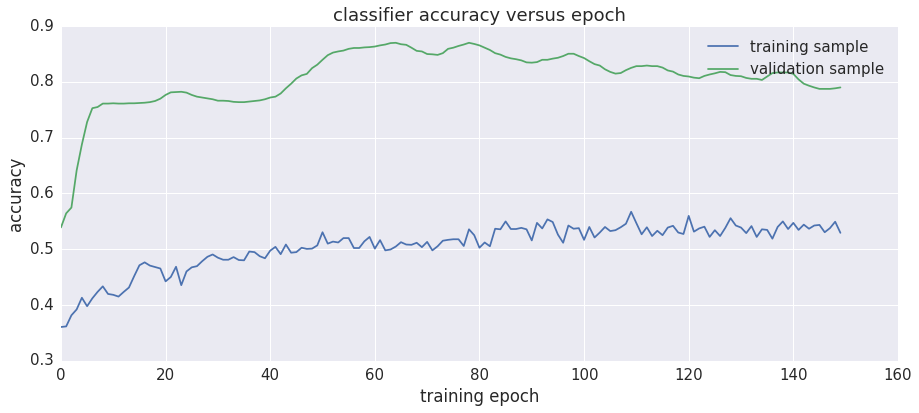

In [98]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['acc']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_acc']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier accuracy versus epoch')
ax.set_ylabel('accuracy')
ax.set_xlabel('training epoch')
ax.legend()
plt.savefig('figs/accuracy.png')

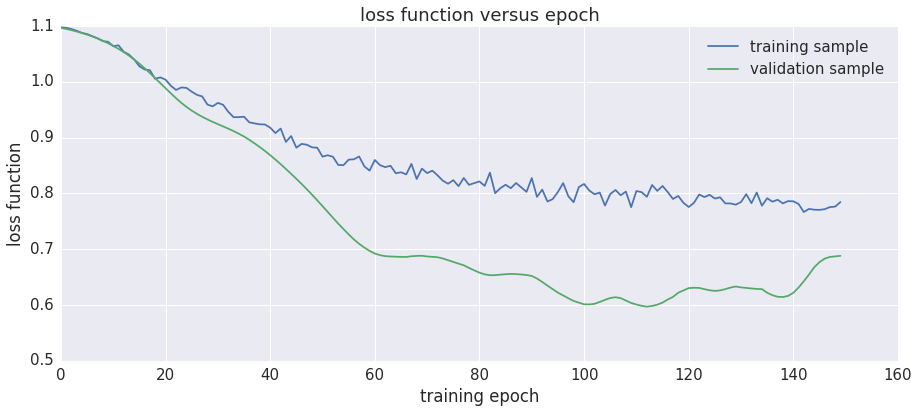

In [99]:
#plot loss function vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('loss function versus epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()
plt.savefig('figs/loss.png')

In [43]:
#model.predict(x_test)